In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic-passenger-data/README.md
/kaggle/input/spaceship-titanic-passenger-data/data/sample_submission.csv
/kaggle/input/spaceship-titanic-passenger-data/data/train.csv
/kaggle/input/spaceship-titanic-passenger-data/data/test.csv


<h3>Import Libraries</h3>

In [2]:
import warnings
import itertools
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr, chi2_contingency
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

<h3>Get Data</h3>

In [3]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic-passenger-data/data/train.csv")

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<h5>We can see that for some of the features, there are values that are missing (null values). Therefore, we must take action. Since, at most, there are about 2.3% of the 8693 entries that are missing for one feature, it would be better to impute (or fill out) those missing values.</h5>

<h3>Missing Value Handling</h3>

<h5>For the string features, we will just replace the null values with the string 'Unknown'. For the numerical features, we will replace the null values with the median age.</h5>

In [6]:
# go through each column with nulls in it and replace them with the appropriate value
for column in train_data.columns:
    if train_data[column].isnull().any():
        if train_data[column].dtype == 'object':
            train_data[column] = train_data[column].fillna('Unknown')          
        elif train_data[column].dtype == 'float64':
            median = train_data[column].median()
            train_data[column] = train_data[column].fillna(median)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<h3>Feature Creation</h3>

<h5>First, we want to extract the group IDs from the passenger IDs since passengers can be part of the same group, and people of the same group may be connected if they were transported or not.</h5>

In [8]:
group_ids = []
for val in train_data['PassengerId']:
    group_id, _ = val.split('_')
    group_ids.append(group_id)

train_data['GroupId'] = group_ids
train_data['GroupId'] = pd.to_numeric(train_data['GroupId'], errors='coerce')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4


<h5>Since the features "Name" and "PassengerId" are unique identifiers, they may not affect the results as much as the other features. For this reason, we wil remove these two columns from the data.</h5>

In [9]:
train_data.drop(['PassengerId', 'Name'], axis=1, inplace=True)

<h5>Now, we have multiple columns for the expenses made for each type of amenity. However, it may make it complicated for the model that will be used if it has multiple columns for the money a passenger has spent. It makes more sense to make a single column of the total amount of money a passenger spent.</h5>

In [10]:
expenses = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
train_data['TotalExpenses'] = expenses.sum(axis=1)
train_data['TotalExpenses']

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: TotalExpenses, Length: 8693, dtype: float64

In [11]:
train_data.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

<h5>Now, I want to split the 'Cabin' column into three separate columns to split the deck, num, and side into their own columns to better process the data. </h5>

In [12]:
deck_col = []
num_col = []
side_col = []

# go through the Cabin column to separate the details of the passenger's 
# location into three (deck, num, side) so that they can be in their 
# own column. 
for val in train_data['Cabin']:
    # Check if the value is a missing value
    if val != 'Unknown':
        # split the string
        deck, num, side = val.split('/')
        
        deck_col.append(deck)
        num_col.append(int(num))
        side_col.append(side)
    else:
        # Add the "Unknown" string to the columns to represent a missing
        # value
        deck_col.append('Unknown')
        num_col.append('427') # median
        side_col.append('Unknown')
        
train_data_new = train_data.drop('Cabin', axis=1)
train_data_new['Deck'] = deck_col
train_data_new['Num'] = num_col
train_data_new['Num'] = pd.to_numeric(train_data_new['Num'], errors='coerce')
train_data_new['Side'] = side_col

In [13]:
train_data_new.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,GroupId,TotalExpenses,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,False,1,0.0,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,True,2,736.0,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,False,3,10383.0,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,False,3,5176.0,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,True,4,1091.0,F,1,S


In [14]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   object 
 1   CryoSleep      8693 non-null   object 
 2   Destination    8693 non-null   object 
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   object 
 5   Transported    8693 non-null   bool   
 6   GroupId        8693 non-null   int64  
 7   TotalExpenses  8693 non-null   float64
 8   Deck           8693 non-null   object 
 9   Num            8693 non-null   int64  
 10  Side           8693 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 687.8+ KB


<h3>Numerical Values Analysis</h3>

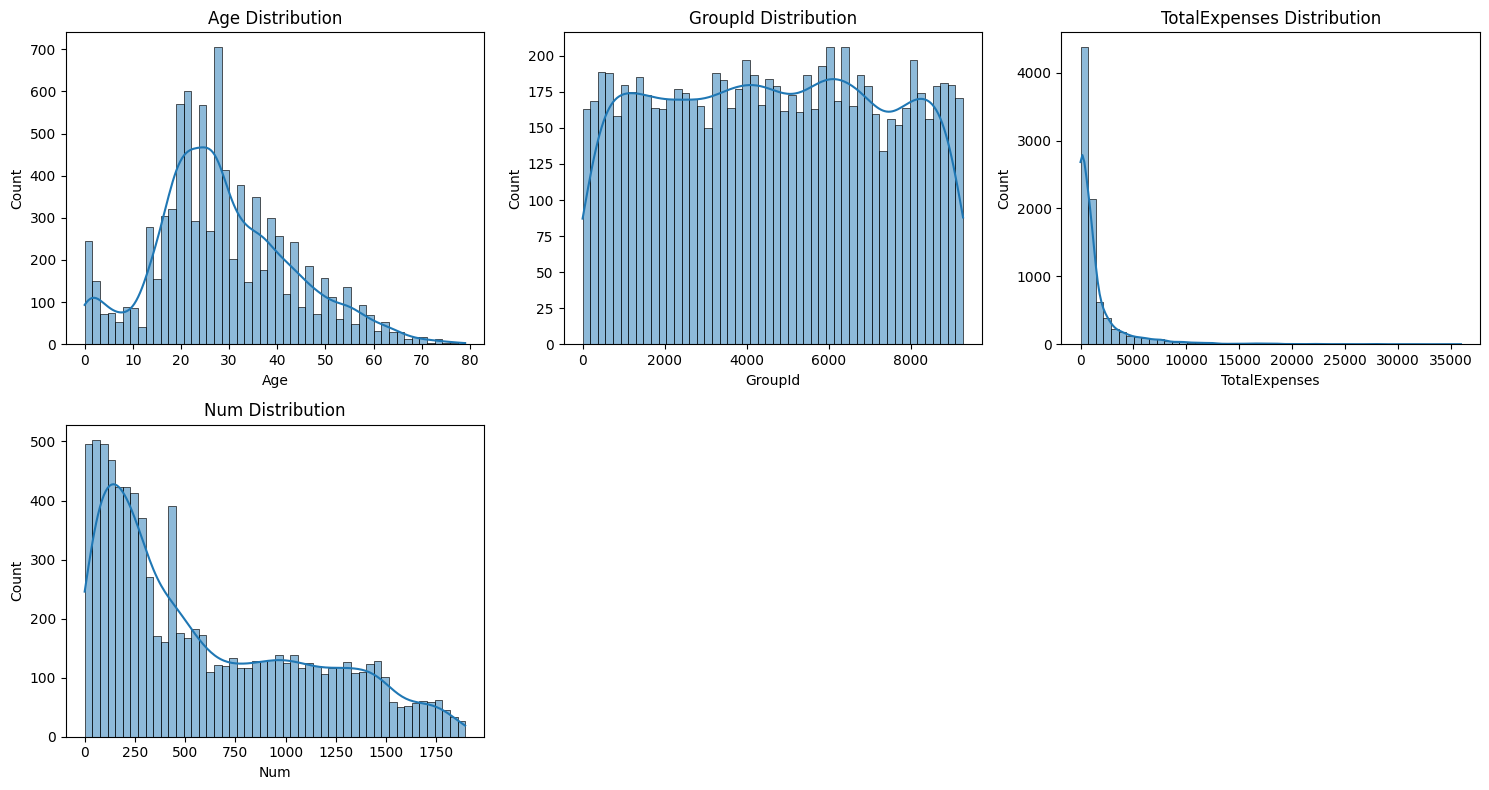

In [15]:
# Select numerical columns
num_cols = train_data_new.select_dtypes(include='number').columns

# Set up the grid
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # Ceiling division
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each histogram
for i, col in enumerate(num_cols, 1):
    warnings.filterwarnings("ignore")
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train_data_new[col], kde=True, bins=50)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

<h5>You can see that the distribution for the "Age" feature is close to being normally distributed, while the distribution of the "Num" feature is skewed to the right (positively skewed). The "TotalExpenses" feature is greatly skewed to the right. The GroupId seems to be spread out fairly evenly.</h5>

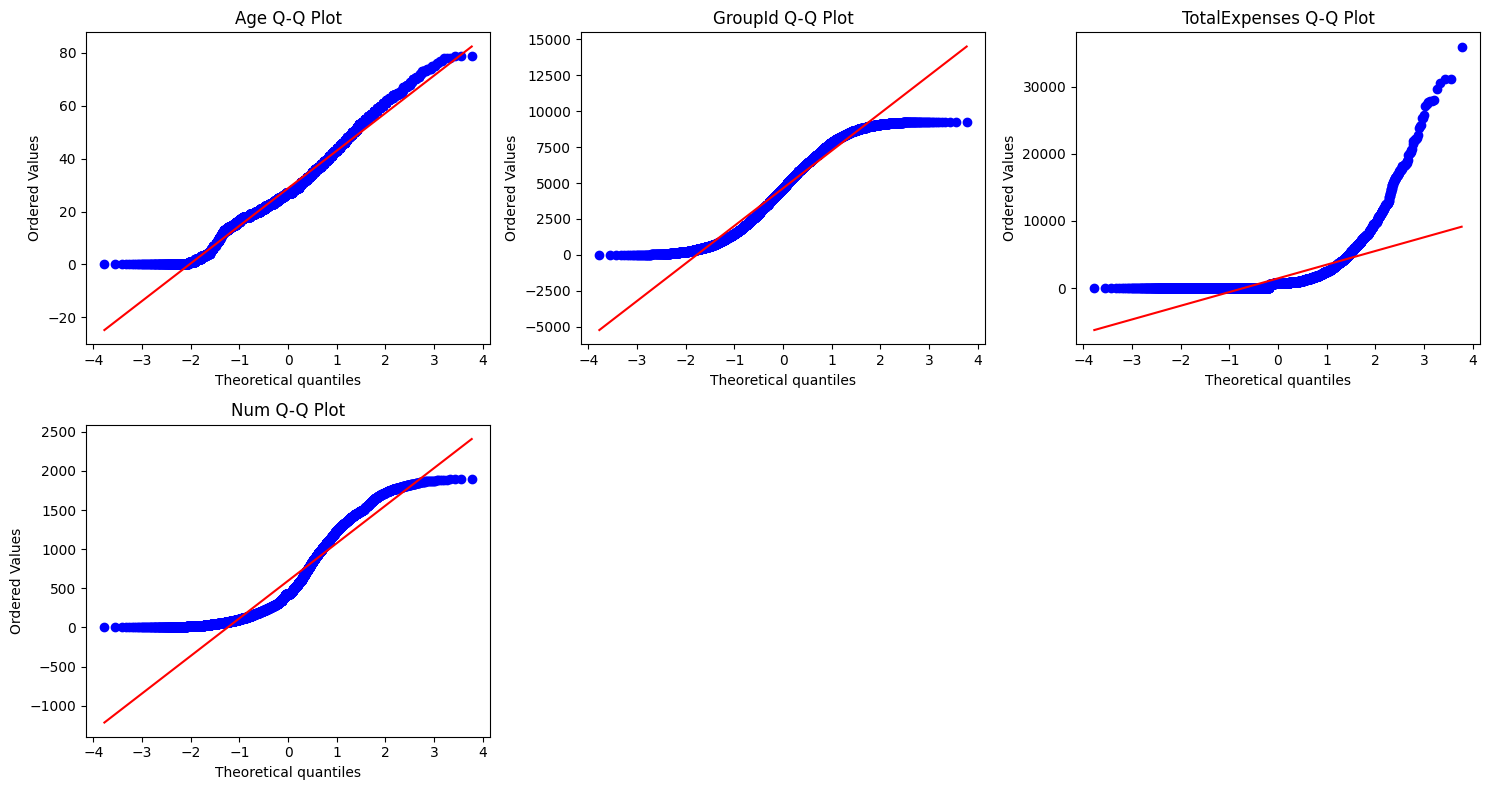

In [16]:
# Set up the grid
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each Q-Q plot
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    stats.probplot(train_data_new[col].dropna(), dist="norm", plot=plt)
    plt.title(f'{col} Q-Q Plot')

plt.tight_layout()
plt.show()

<h5>The Q-Q plots confirm the results from the histograms by showing that the "Age" feature is mostly normally distributed and the 'num' feature is rightly skewed. The "TotalExpenses" feature also seems to be rightly skewed. However, for the "GroupId" feature, it is difficult to see if it is normally distributed in the middle or not. Let's confirm the observations by analyzing them numerically rather than visually.</h5>

In [17]:
# go through each column with numerical values and find its skew value
for col in train_data_new.columns:
    if train_data_new[col].dtype == 'float64' or train_data_new[col].dtype == 'int64':
        skew_value = train_data_new[col].skew()
        print(f"{col} Skew Value: {skew_value}")

Age Skew Value: 0.43110235678108527
GroupId Skew Value: 0.00202022187590881
TotalExpenses Skew Value: 4.417588190022685
Num Skew Value: 0.7464580436841154


<h5>Values between -0.5 and 0.5 are normally distributed, and anything >0.5 is right skewed. You can see that the values match the observations made with the Q-Q plots for all features except the "GroupID" feature. It seems like it is normally distributed, which was not obvious visually. Now, let's see how many outliers each numerical feature has.</h5>

<h3>Outlier and Noise Handling</h3>

<h5>We will use the interquartile range to determine the outlier count.</h5>

In [18]:
def detect_outliers_iqr(df):
    outlier_flags = {}
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_flags[col] = len(outliers)
    return pd.Series(outlier_flags).sort_values(ascending=False)

In [19]:
outliers = detect_outliers_iqr(train_data_new)
outliers

TotalExpenses    934
Age              162
GroupId            0
Num                0
dtype: int64

<h5>We can see that for the features "Age","Num", and "GroupId" features, the outliers wouldn't affect the model that will be used later for classification as much as the "TotalExpenses" feature (which has >10% of its values being outliers). So, we need to focus on that feature and figure out what to do with it.</h5>

<h5>As you can see, the feature that has a lot of outliers is the one representing the money spent on amenities. This is realistic since the passenger may be a VIP passenger or just a wealthy one who has spent a lot on an amenity they enjoy. So, it may be better to keep those datapoints, but can instead transform this feature so that the outliers won't affect the results later on, especially for models that are affected by outliers.</h5>

In [20]:
# go through the features with a lot of outliers and use the log function to transform
# the values to reduce the impact of the outliers.  
train_data_new['TotalExpenses_log'] = np.log1p(train_data_new['TotalExpenses'])

In [21]:
train_data_new.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,GroupId,TotalExpenses,Deck,Num,Side,TotalExpenses_log
0,Europa,False,TRAPPIST-1e,39.0,False,False,1,0.0,B,0,P,0.000000
1,Earth,False,TRAPPIST-1e,24.0,False,True,2,736.0,F,0,S,6.602588
2,Europa,False,TRAPPIST-1e,58.0,True,False,3,10383.0,A,0,S,9.248021
3,Europa,False,TRAPPIST-1e,33.0,False,False,3,5176.0,A,0,S,8.551981
4,Earth,False,TRAPPIST-1e,16.0,False,True,4,1091.0,F,1,S,6.995766


<h3>Turning Categorical Values into Numerical</h3>

<h5>Since ML models usually take in numerical data, we must turn the columns with string types into numerical values. One way to do this is through one-hot encoding. Pandas has a built-in method that can do one-hot encoding for the columns in a DataFrame, so we will use that.</h5>

In [22]:
col = ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side']
train_data_new['VIP'] = train_data_new['VIP'].astype(bool)
train_data_encoded = pd.get_dummies(train_data_new, columns=col)

In [23]:
train_data_encoded.head()

,Age,VIP,Transported,GroupId,TotalExpenses,Num,TotalExpenses_log,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,39.0,False,False,1,0.0,0,0.000000,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,24.0,False,True,2,736.0,0,6.602588,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,58.0,True,False,3,10383.0,0,9.248021,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,33.0,False,False,3,5176.0,0,8.551981,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,16.0,False,True,4,1091.0,1,6.995766,True,False,False,...,False,False,False,True,False,False,False,False,True,False


<h3>Feature Scaling</h3>

<h5>Now, to make sure all the numerical values are on the same scale(not including the one-hot encodings), we will scale them. Since there exist some outliers, standardization is a better option than normalization. Going to create two dataframes, one where the features with outliers were not transformed with the log function, and one where the features with outliers were transformed. This is because some of the models aren't affected by outliers, so I want to see which dataframe works better with those models.</h5>

In [24]:
scaler = StandardScaler()
train_data_scaled = train_data_encoded.copy(deep=True).drop(['TotalExpenses'], axis=1)
train_data_not_transformed = train_data_encoded.copy(deep=True).drop(['TotalExpenses_log'], axis=1)

# go through each column with numerical values (not including one-hot encodings)
# and standardize them
for col1, col2 in zip(train_data_scaled.select_dtypes(include='number').columns, train_data_not_transformed.select_dtypes(include='number').columns):
    train_data_scaled[col1] = scaler.fit_transform(train_data_scaled[[col1]])
    train_data_not_transformed[col2] = scaler.fit_transform(train_data_not_transformed[[col2]])

In [25]:
train_data_scaled.head()

,Age,VIP,Transported,GroupId,Num,TotalExpenses_log,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,0.711945,False,False,-1.734409,-1.177238,-1.152845,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,-0.334037,False,True,-1.734034,-1.177238,0.636892,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,2.036857,True,False,-1.733660,-1.177238,1.353979,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0.293552,False,False,-1.733660,-1.177238,1.165307,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,-0.891895,False,True,-1.733286,-1.175264,0.743469,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [26]:
train_data_not_transformed.head()

,Age,VIP,Transported,GroupId,TotalExpenses,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,0.711945,False,False,-1.734409,-0.514066,-1.177238,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,-0.334037,False,True,-1.734034,-0.251479,-1.177238,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,2.036857,True,False,-1.733660,3.190333,-1.177238,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0.293552,False,False,-1.733660,1.332604,-1.177238,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,-0.891895,False,True,-1.733286,-0.124824,-1.175264,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


<h3>Feature Selection</h3>

<h5>Now, to have the optimal dataset to use for the ML models, we need to find out which features are important and which are not to further clean the dataset. We will use three methods to figure out the important features.</h5>

In [27]:
correlations = {}
p_scores = {}

for col in train_data_scaled.select_dtypes(include='number').columns:
    corr, p = pointbiserialr(train_data_scaled[col], train_data_scaled['Transported'])
    correlations[col] = corr
    p_scores[col] = p

# Sort and display
print(pd.Series(correlations).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

GroupId              0.021491
Num                 -0.044502
Age                 -0.074233
TotalExpenses_log   -0.468941
dtype: float64


GroupId              4.510427e-02
Num                  3.315266e-05
Age                  4.216286e-12
TotalExpenses_log    0.000000e+00
dtype: float64

<h5>We can see that "TotalExpenses_log" has a strong negative correlation. The others have weak negative correlations. You can see that "TotalExpenses_log" is highly statistically significant, so for sure it will be used in model training. 'Num' and 'Age', although weak in correlation, are still significant (not as high as 'TotalExpenses_log' though), so they will need further testing in model training and testing. "GroupId" has a low statistical significance, so it probably doesn't have a huge say if a passenger was transported or not, but sometimes if mixed with another feature, it can lead to it being important.</h5>

In [28]:
correlations = {}
p_scores = {}

for col in train_data_not_transformed.select_dtypes(include='number').columns:
    corr, p = pointbiserialr(train_data_not_transformed[col], train_data_not_transformed['Transported'])
    correlations[col] = corr
    p_scores[col] = p

# Sort and display
print(pd.Series(correlations).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

GroupId          0.021491
Num             -0.044502
Age             -0.074233
TotalExpenses   -0.199514
dtype: float64


GroupId          4.510427e-02
Num              3.315266e-05
Age              4.216286e-12
TotalExpenses    9.382847e-79
dtype: float64

<h5>For the non-transformed data, we can see similar results, other than the fact that 'TotalExpenses' has a lower correlation score. This could possibly be the fact that the outliers were kept, affecting correlation results. The statistical significance stayed about the same, so the same testing must be done for this dataset as well.</h5>

In [29]:
categorical_columns = [col for col in train_data_new.columns if train_data_new[col].dtype == 'object' or train_data_new[col].dtype == 'bool']
chi2_scores = {}
p_scores = {}

for col in categorical_columns:
    if col != 'Transported':
        table = pd.crosstab(train_data_new[col], train_data_new['Transported'])
        chi2, p, _, _ = chi2_contingency(table)
        chi2_scores[col] = chi2
        p_scores[col] = p

# Sort and display
print(pd.Series(chi2_scores).sort_values(ascending=False))
pd.Series(p_scores).sort_values(ascending=False)

CryoSleep      1861.749116
Deck            392.288750
HomePlanet      324.967237
Destination     106.394882
Side             91.475193
VIP               5.029829
dtype: float64


VIP            2.491436e-02
Side           1.369034e-20
Destination    6.547434e-23
HomePlanet     3.921492e-70
Deck           8.352488e-80
CryoSleep      0.000000e+00
dtype: float64

<h5>We can see that the features "CryoSleep", "Deck", "HomePlanet", "Destination", and "Side" have strong chi2 scores, while "VIP" has a weak chi2 score. They are all statistically significant, so "VIP" will need further testing in model testing and training. Also note, CryoSleep seems to be VERY conencted to the result.</h5>

<h3>Model Training</h3>

<Axes: xlabel='Transported'>

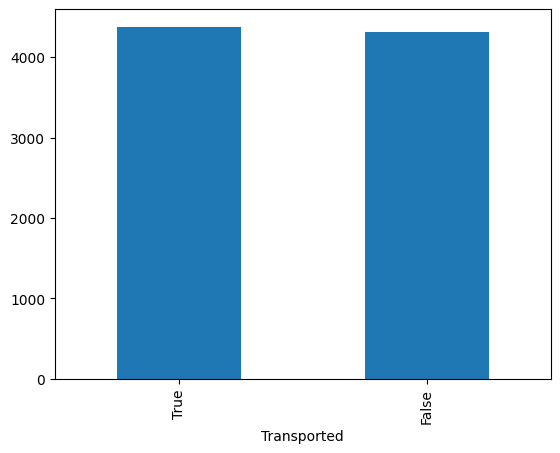

In [30]:
train_data_scaled['Transported'].value_counts().plot.bar()

<h5>We can see that the target column is almost balanced and that it doesn't skew towards one of the values too much, so we do not need to take extra measures like using F1 score as a metric. We can just use accuracy to determine how well a model performs. </h5>

In [31]:
X_scaled = train_data_scaled.drop('Transported', axis=1)
X_not_transformed = train_data_not_transformed.drop('Transported', axis=1)
y = train_data_scaled['Transported']

In [32]:
models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest" : RandomForestClassifier(n_estimators=100,
                                            random_state=42,
                                            n_jobs=-1),
    "XGB" : XGBClassifier(random_state=42),
    "Gradient Boosting" : GradientBoostingClassifier(random_state=42),
    "KNN" : KNeighborsClassifier(n_neighbors=5)
}

<h5>A reminder that we will need to remove the features that need further testing (found out during feature selection) one by one to determine their importance on the results of the model. Of course, we have to be careful of overfitting. </h5>

In [33]:
train_data_scaled.columns

Index(['Age', 'VIP', 'Transported', 'GroupId', 'Num', 'TotalExpenses_log',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'HomePlanet_Unknown', 'CryoSleep_False', 'CryoSleep_True',
       'CryoSleep_Unknown', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'Destination_Unknown', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Side_P', 'Side_S',
       'Side_Unknown'],
      dtype='object')

In [34]:
print("====== Cross Validation for Dataset with Transformed Outliers ======")
print()
feature_groups = {
    'VIP': ['VIP'], 
    'Num' : ['Num'], 
    'Age' : ['Age'], 
    'GroupId' : ['GroupId'], 
    'Side' : ['Side_P', 'Side_S', 'Side_Unknown'], 
    'Deck' : ['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T','Deck_Unknown'],
    'Destination' : ['Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'Destination_Unknown'], 
    'HomePlanet' : ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'HomePlanet_Unknown']}

columns_to_test = list(feature_groups.keys())

# go through each classifier and do cross validation on them
for name, clf in models.items():
    print(f"******** {name} *********")
    print()

    results = []

    # no columns removed
    baseline_acc = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
    results.append({
        'dropped_cols': (),
        'mean_acc': baseline_acc.mean(),
        'std_acc': baseline_acc.std()
    })

    # Find every subset of the columns that need further testing and remove them from
    # dataset to see if any has an affect on the results
    for r in range(1, len(columns_to_test) + 1):
        for group_subset in itertools.combinations(columns_to_test, r):
            cols_to_drop = []
            for group in group_subset:
                cols_to_drop.extend(feature_groups[group])
                
            X_train = X_scaled.drop(cols_to_drop, axis=1)
        
            cv_acc = cross_val_score(clf, X_train, y, cv=5, scoring='accuracy', n_jobs=-1)

            results.append({
                'dropped_cols': group_subset,
                'mean_acc': cv_acc.mean(),
                'std_acc': cv_acc.std()
            })

    results_df = pd.DataFrame(results).sort_values('mean_acc', ascending=False)
    print(results_df)
    print()

====== Cross Validation for Dataset with Transformed Outliers ======

******** Logistic Regression *********

                                dropped_cols  mean_acc   std_acc
166     (VIP, Num, Age, GroupId, HomePlanet)  0.741978  0.010462
101          (VIP, Num, GroupId, HomePlanet)  0.741863  0.010663
66                (Num, GroupId, HomePlanet)  0.741518  0.010063
131          (Num, Age, GroupId, HomePlanet)  0.741518  0.009906
143  (Num, GroupId, Destination, HomePlanet)  0.741403  0.011621
..                                       ...       ...       ...
49                      (VIP, GroupId, Deck)  0.728288  0.013640
40                          (VIP, Num, Deck)  0.728173  0.011199
109                (VIP, Age, GroupId, Deck)  0.727943  0.013522
74                      (Age, GroupId, Deck)  0.727712  0.012850
28                           (GroupId, Deck)  0.727712  0.013664

[256 rows x 3 columns]

******** Random Forest *********

                                          dropped_c

In [35]:
print("====== Cross Validation for Dataset with Outliers ======")
columns_to_test = ['VIP', 'GroupId', 'Num', 'Age']

# go through each classifier and do cross validation on them
for name, clf in models.items():
    print(f"******** {name} *********")
    print()
    
    results = []

    # no columns removed
    baseline_acc = cross_val_score(clf, X_not_transformed, y, cv=5, scoring='accuracy', n_jobs=-1)
    results.append({
        'dropped_cols': (),
        'mean_acc': baseline_acc.mean(),
        'std_acc': baseline_acc.std()
    })

    # Find every subset of the columns that need further testing and remove them from
    # dataset to see if any has an affect on the results
    for r in range(0, len(columns_to_test) + 1):
        for subset in itertools.combinations(columns_to_test, r):
            X_train = X_not_transformed.drop(list(subset), axis=1)

            warnings.filterwarnings("ignore")
            cv_acc = cross_val_score(clf, X_train, y, cv=5, scoring='accuracy', n_jobs=-1)

            results.append({
                'dropped_cols': subset,
                'mean_acc': cv_acc.mean(),
                'std_acc': cv_acc.std()
            })

    results_df = pd.DataFrame(results).sort_values('mean_acc', ascending=False)
    print(results_df)
    print()

====== Cross Validation for Dataset with Outliers ======
******** Logistic Regression *********

                dropped_cols  mean_acc   std_acc
9             (GroupId, Num)  0.727599  0.007626
12       (VIP, GroupId, Num)  0.726908  0.007236
16  (VIP, GroupId, Num, Age)  0.725873  0.010598
15       (GroupId, Num, Age)  0.725298  0.010095
7                 (VIP, Num)  0.724606  0.009119
4                     (Num,)  0.724146  0.009682
3                 (GroupId,)  0.721500  0.013402
2                     (VIP,)  0.721499  0.012687
6             (VIP, GroupId)  0.721385  0.013061
0                         ()  0.721039  0.013154
1                         ()  0.721039  0.013154
11                (Num, Age)  0.720810  0.010062
14           (VIP, Num, Age)  0.720350  0.009977
8                 (VIP, Age)  0.716668  0.015049
5                     (Age,)  0.716553  0.015235
13       (VIP, GroupId, Age)  0.716323  0.014988
10            (GroupId, Age)  0.716207  0.015014

******** Random Fore

<h3>Model Testing</h3>

<h3>Results</h3>